<a href="https://colab.research.google.com/github/i-ganza007/Sentiment_Analysis_Formative/blob/main/LSTM_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('omw-1.4')
nltk.download('stopwords')

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression


import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    LSTM, Bidirectional, Dense, Dropout, Masking
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping


[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
path = '/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv'
df = pd.read_csv(path)

df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [ ]:
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'http\S+|www\S+', '', text)
    text = re.sub(r'[^a-z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words]
    return " ".join(tokens)

df['clean_review'] = df['review'].apply(preprocess_text)

df[['review', 'clean_review']].head()


,review,clean_review
0,One of the other reviewers has mentioned that ...,one reviewers mentioned watching oz episode yo...
1,A wonderful little production. <br /><br />The...,wonderful little production filming technique ...
2,I thought this was a wonderful way to spend ti...,thought wonderful way spend time hot summer we...
3,Basically there's a family where a little boy ...,basically theres family little boy jake thinks...
4,"Petter Mattei's ""Love in the Time of Money"" is...",petter matteis love time money visually stunni...


In [ ]:
df['sentiment'] = df['sentiment'].map({'negative': 0, 'positive': 1})

In [ ]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['sentiment'])

train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42, stratify=train_df['sentiment'])

print(f"Train size: {len(train_df)}")
print(f"Validation size: {len(val_df)}")
print(f"Test size: {len(test_df)}")


Train size: 32000
Validation size: 8000
Test size: 10000


In [ ]:
train_df['tokens'] = train_df['clean_review'].apply(word_tokenize)
val_df['tokens'] = val_df['clean_review'].apply(word_tokenize)
test_df['tokens'] = test_df['clean_review'].apply(word_tokenize)

train_df[['clean_review', 'tokens']].head()


,clean_review,tokens
26680,oh yes agree others describe appalling acting ...,"[oh, yes, agree, others, describe, appalling, ..."
16648,basic hook lincoln slow slowness represents th...,"[basic, hook, lincoln, slow, slowness, represe..."
29967,utter trash im huge fan cusacks sole reason wa...,"[utter, trash, im, huge, fan, cusacks, sole, r..."
34122,meet cosmo jason priestley nerdy young bookie ...,"[meet, cosmo, jason, priestley, nerdy, young, ..."
823,dont know people criticise show muchit great f...,"[dont, know, people, criticise, show, muchit, ..."


In [ ]:

w2v_model = Word2Vec(sentences=train_df['tokens'], vector_size=200, window=6, min_count=2)

def tokens_to_sequence(tokens):
    vectors = [w2v_model.wv[word] for word in tokens if word in w2v_model.wv]
    return vectors

X_train_seq_w2v = train_df['tokens'].apply(tokens_to_sequence).tolist()
X_val_seq_w2v = val_df['tokens'].apply(tokens_to_sequence).tolist()
X_test_seq_w2v = test_df['tokens'].apply(tokens_to_sequence).tolist()

In [ ]:
max_len = 280
vector_size = 200

X_train_seq_padded = pad_sequences(X_train_seq_w2v, maxlen=max_len,
                                   dtype='float32',padding='post',
                                   truncating='post', value=0.0)
X_val_seq_padded = pad_sequences(X_val_seq_w2v, maxlen=max_len,
                                 dtype='float32',padding='post',
                                 truncating='post', value=0.0)
X_test_seq_padded = pad_sequences(X_test_seq_w2v, maxlen=max_len,
                                  dtype='float32',padding='post',
                                  truncating='post', value=0.0)


In [ ]:
model = Sequential([
    Masking(mask_value=0.0, input_shape=(max_len, vector_size)),
    Bidirectional(LSTM(256, return_sequences=True,
                       kernel_regularizer=regularizers.l2(0.0005))),
    Dropout(0.4),
    Bidirectional(LSTM(128, kernel_regularizer=regularizers.l2(0.0005))),
    Dropout(0.4),
    Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.0005)),
    Dropout(0.4),
    Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.0005)),
    Dropout(0.4),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy',
              optimizer= Adam(learning_rate=0.001),
              metrics=['accuracy'])

history = model.fit(X_train_seq_padded,
                    train_df['sentiment'],
                    epochs=12,
                    batch_size=64,
                    validation_data=(X_val_seq_padded, val_df['sentiment']))


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/12
500/500 ━━━━━━━━━━━━━━━━━━━━ 59s 105ms/step - accuracy: 0.7825 - loss: 0.9491 - val_accuracy: 0.8558 - val_loss: 0.5070
Epoch 2/12
500/500 ━━━━━━━━━━━━━━━━━━━━ 47s 93ms/step - accuracy: 0.8585 - loss: 0.4862 - val_accuracy: 0.8799 - val_loss: 0.3802
Epoch 3/12
500/500 ━━━━━━━━━━━━━━━━━━━━ 47s 94ms/step - accuracy: 0.8691 - loss: 0.3983 - val_accuracy: 0.8848 - val_loss: 0.3423
Epoch 4/12
500/500 ━━━━━━━━━━━━━━━━━━━━ 47s 93ms/step - accuracy: 0.8773 - loss: 0.3652 - val_accuracy: 0.8830 - val_loss: 0.3288
Epoch 5/12
500/500 ━━━━━━━━━━━━━━━━━━━━ 47s 93ms/step - accuracy: 0.8815 - loss: 0.3482 - val_accuracy: 0.8855 - val_loss: 0.3320
Epoch 6/12
500/500 ━━━━━━━━━━━━━━━━━━━━ 46s 93ms/step - accuracy: 0.8881 - loss: 0.3283 - val_accuracy: 0.8710 - val_loss: 0.3487
Epoch 7/12
500/500 ━━━━━━━━━━━━━━━━━━━━ 47s 93ms/step - accuracy: 0.8897 - loss: 0.3212 - val_accuracy: 0.8802 - val_loss: 0.3245
Epoch 8/12
500/500 ━━━━━━━━━━━━━━━━━━━━ 47s 93ms/step - accuracy: 0.8965 - loss: 0.3089 -

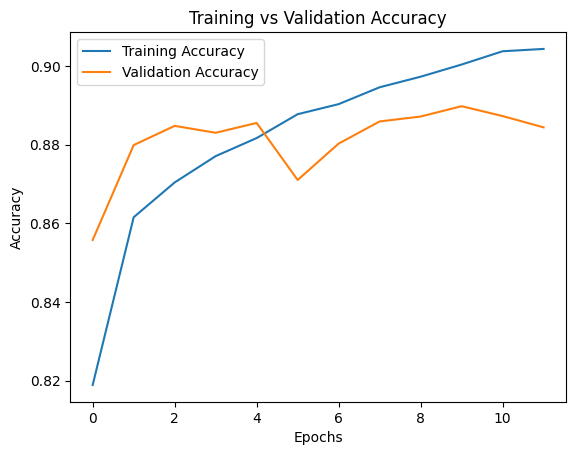

In [ ]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_true, bilstm_preds, target_names=['Negative','Positive']))


              precision    recall  f1-score   support

    Negative       0.92      0.85      0.88      5000
    Positive       0.86      0.92      0.89      5000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



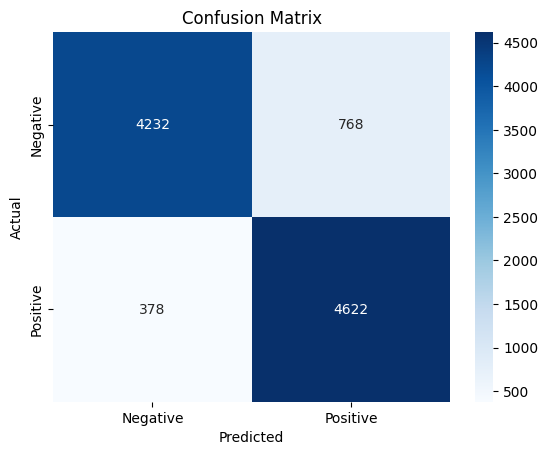

In [ ]:
import seaborn as sns

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [ ]:

bilstm_probs = model.predict(X_test_seq_padded)
bilstm_preds = (bilstm_probs > 0.5).astype(int).flatten()


y_true = test_df['sentiment']

prec = precision_score(y_true, bilstm_preds)
rec = recall_score(y_true, bilstm_preds)
f1 = f1_score(y_true, bilstm_preds)
cm = confusion_matrix(y_true, bilstm_preds)
acc = accuracy_score(y_true, bilstm_preds)

print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1-score: {f1:.4f}")
print("Confusion Matrix:")
print(cm)



313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step
Accuracy: 0.8854
Precision: 0.8575
Recall: 0.9244
F1-score: 0.8897
Confusion Matrix:
[[4232  768]
 [ 378 4622]]
